In [12]:
import psycopg2
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import manifold
import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib import offsetbox
from time import time




df = pd.read_csv("stock_data_2000_2019.csv")
pd.set_option('display.expand_frame_repr', False)

"""fill in NANs with np.nans"""
df.fillna(value = pd.np.nan, inplace=True)

missing_stocks = []
"""create list of stocks that will go into analysis"""
"""keep only stocks that have existed from 2009-2018"""
for column_name in df.columns:
    if sum(df[column_name].isnull())==df.shape[0]:
        missing_stocks.append(column_name)
        
keep_stocks = [stock_symbol for stock_symbol in df.columns if stock_symbol not in missing_stocks]

"""remove date vector from df"""
"""keep the stocks that are not null"""
date_vector = df['date']
keep_df = df[keep_stocks]



"""transpose the dataframe so that the dates are the columns & stocks are the indices"""
df_trans = keep_df.T
df_trans.columns= date_vector
df_trans = df_trans.iloc[1:, :]
#df_trans.head()



"""load up the Sector table"""
symbol_industry = pd.read_excel('stock_symbols.xlsx', sheet_name='data')
symbol_industry.index = symbol_industry['Symbol']

#symbol_industry.head()
symbool_industry_red = symbol_industry[['GICS Sector']]
#symbool_industry_red.head()


"""merge the DF of sectors with the DF of stock returns"""
full_df = pd.merge(symbool_industry_red, df_trans, how='inner', on=None, left_on=None, right_on=None,
         left_index=True, right_index=True, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False)

#full_df.head()


"""change column names"""
date_string_vec = [str(x) for x in full_df.columns]
date_string_vec = [date_string_vec[i].split(' ')[0] for i in range(len(date_string_vec))]
date_string_vec[0] = 'Sector'
full_df.columns = date_string_vec
#full_df.head()


"""stocks that havent been trading from 2009-2018 will not be included"""
list_of_null_stocks = []

for stock_symbol in full_df.index:
    if full_df[full_df.index==stock_symbol].isnull().sum().sum() > 0:
        list_of_null_stocks.append(stock_symbol)
        

"""drop those stocks"""        
full_df_red = full_df.drop(list_of_null_stocks, axis=0)        
#full_df_red.head(2)




###################################
###########---------------------------
###################################
###########---------break data into yearly table------------------
###################################
###########---------
returns_df = full_df_red.iloc[:, 1:].T
returns_df.index = pd.to_datetime(returns_df.index)

"""create a df for each year"""
df09_18 = returns_df[(returns_df.index >= '2009-01-01') & (returns_df.index < '2019-01-01')].T
df19 = returns_df[(returns_df.index >= '2019-01-01') & (returns_df.index < '2019-10-01')].T

#df09_18.head(2)


###################################
###########---------------------------
###################################
###########---------normalize and merge data------------------
###################################
###########---------

#process_df = full_df_red.iloc[:, 1:]
X_scaled = StandardScaler().fit_transform(df09_18)
X_scaled_df = pd.DataFrame(X_scaled, index = df09_18.index, columns = df09_18.columns)
#X_scaled_df.head(2)



"""merge the df with their industries"""
df09_18 = pd.merge(symbool_industry_red, df09_18, how='inner', on=None, left_on=None, right_on=None,
         left_index=True, right_index=True, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False)
""""""
df19 = pd.merge(symbool_industry_red, df19, how='inner', on=None, left_on=None, right_on=None,
         left_index=True, right_index=True, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False)



"""change column names to make things more manageable"""
temp_list = df09_18.columns.tolist()
temp_list[0] = 'Sector'
df09_18.columns = temp_list
""""""
temp_list = df19.columns.tolist()
temp_list[0] = 'Sector'
df19.columns = temp_list


###################################
###########---------------------------
###################################
###########---------add color and remerge------------------
################################

"""add the color code dataframe"""
color_df = pd.DataFrame(index=['Health Care',
'Industrials',
'Consumer Discretionary',
'Information Technology',
'Consumer Staples',
'Utilities',
'Financials',
'Real Estate',
'Materials',
'Energy',
'Communication Services'], columns = ['color'], data= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])


"""merge the color df to the returns dataframes"""
df09_18 = pd.merge(color_df, df09_18, how='inner', on=None, left_on=None, right_on='Sector',
         left_index=True, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False)
""""""
df19 = pd.merge(color_df, df19, how='inner', on=None, left_on=None, right_on='Sector',
         left_index=True, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False)
#df09_18.head(2)

,color,Sector,2009-01-02 00:00:00,2009-01-05 00:00:00,2009-01-06 00:00:00,2009-01-07 00:00:00,2009-01-08 00:00:00,2009-01-09 00:00:00,2009-01-12 00:00:00,2009-01-13 00:00:00,...,2018-12-17 00:00:00,2018-12-18 00:00:00,2018-12-19 00:00:00,2018-12-20 00:00:00,2018-12-21 00:00:00,2018-12-24 00:00:00,2018-12-26 00:00:00,2018-12-27 00:00:00,2018-12-28 00:00:00,2018-12-31 00:00:00
ATVI,10,Communication Services,0.0387007,-0.0277778,-0.0715096,0.107317,0.00108108,0.00108108,-0.0461216,0.00659341,...,-0.0109244,-0.00900524,-0.0211282,0.0188393,-0.0371693,-0.029989,0.0447896,0.0290965,-0.010989,-0.0099915
CMCSA,10,Communication Services,0.0759569,-0.0432584,0.00525088,-0.0185786,0.0229885,-0.0405405,-0.0356265,-0.0229446,...,-0.00494641,-0.0222161,-0.0175879,-0.0170358,-0.0265836,-0.0192764,0.0264582,0.0198225,-0.0146299,-0.00699913


In [13]:
df_open19 = pd.read_csv('stock_open_prices.csv')
#pd.set_option('display.expand_frame_repr', False);
df_open19.index = df_open19['date']
df_open19 = df_open19.drop(columns='date')
#df_open19.head(1)

df_close19 = pd.read_csv('stock_close_prices.csv')
#pd.set_option('display.expand_frame_repr', False);
df_close19.index = df_close19['date']
df_close19.index = pd.to_datetime(df_close19.index, format='%d/%b/%Y', infer_datetime_format=True)
df_close19 = df_close19.drop(columns='date')

df_close19 = df_close19[df_close19.index >= '2019-01-01']


"""create 3quarter returns"""

def total_return(input_column):
    per_return = (input_column[-1]-input_column[0])/input_column[0]
    return per_return

## Plotting tSNE and testing Perplexity

In [14]:
def plot_embedding(X, y, title=None):
    x_min, x_max = np.min(X, 0)-5, np.max(X, 0)+5
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
    plt.show()
        
        
def colorize_kmeans(data, num_clusters, num_iter=10, title=None):
    reduced_data = data
    kmeans = KMeans(init='k-means++', n_clusters=num_clusters, n_init=num_iter) ## 3 clusters run with 
    kmeans.fit(reduced_data)
    
    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 5., reduced_data[:, 0].max() + 5.
    y_min, y_max = reduced_data[:, 1].min() - 5., reduced_data[:, 1].max() + 5.
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker = 'x',
                #marker=[str(centroids[i]) for i in range(len(centroids))], 
                s=75, linewidths=3,
                color='w', zorder=10)
    ## plot cluster numbers
    centroid_num_list = [str(i) for i in range(num_clusters)]
    for value, marker in enumerate(centroid_num_list):
        plt.text(kmeans.cluster_centers_[value, 0]+.03, kmeans.cluster_centers_[value, 1]+.01, s = marker, 
                 fontdict= {'family' : 'normal', 'weight' : 'bold','size': 22}, c='w')
    
    #plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
              #'Centroids are marked with white cross')
    plt.title(title)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    #plt.xticks(())
    #plt.yticks(())
    plt.show()
    return kmeans     

In [15]:
"""All years analysis"""
X09_18 = df09_18.iloc[:, 2:]
industry_values = df09_18.iloc[:, 1]
y_all = df09_18.iloc[:, 0]

"""fit the PCA all years"""
pca = PCA(n_components=100)
pca.fit(X09_18)
X09_18 = pca.transform(X09_18)

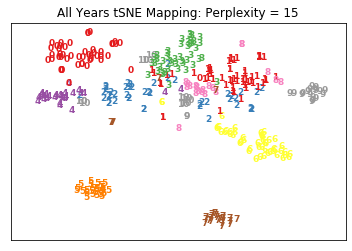

begin kmenans


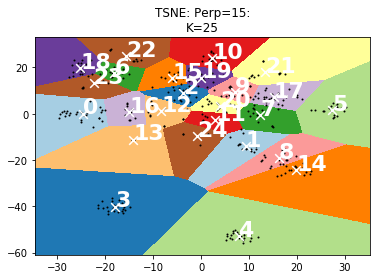

The best cluster was cluster 15
best df has shape (2514, 11)
reduce df final has shape (188, 11)
(188, 10)
Cluster 15 had a total return of 0.32231143519374733 in the first 3 quarters of 2019


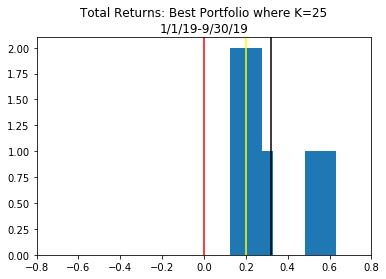

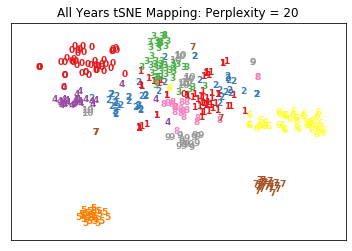

begin kmenans


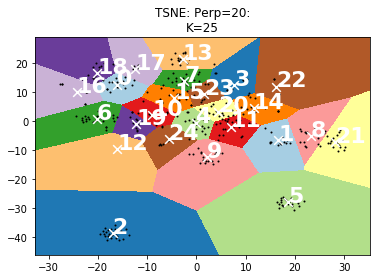

The best cluster was cluster 17
best df has shape (2514, 6)
reduce df final has shape (188, 6)
(188, 6)
Cluster 17 had a total return of 0.11371427518216792 in the first 3 quarters of 2019


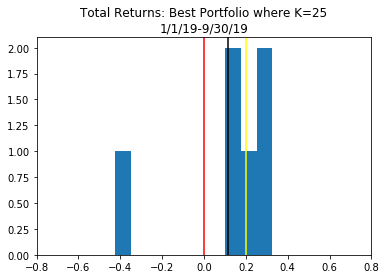

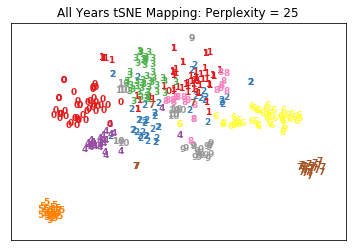

begin kmenans


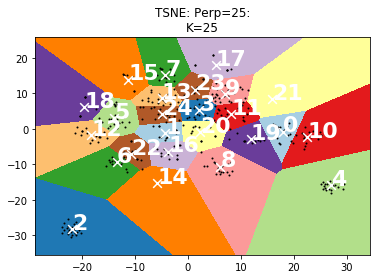

The best cluster was cluster 13
best df has shape (2514, 20)
reduce df final has shape (188, 20)
(188, 19)
Cluster 13 had a total return of 0.1845177428996172 in the first 3 quarters of 2019


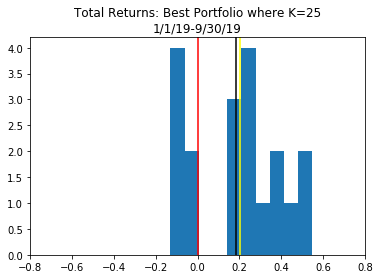

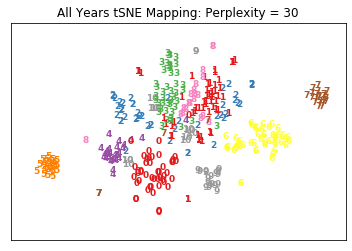

begin kmenans


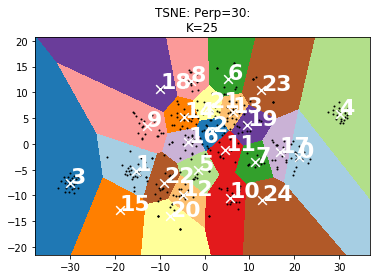

The best cluster was cluster 24
best df has shape (2514, 2)
reduce df final has shape (188, 2)
(188, 2)
Cluster 24 had a total return of 0.4482867852348159 in the first 3 quarters of 2019


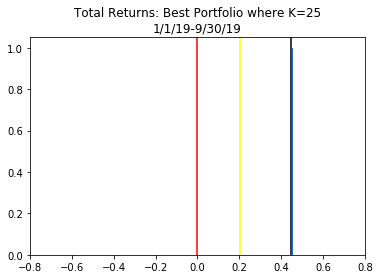

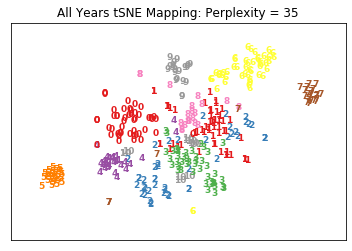

begin kmenans


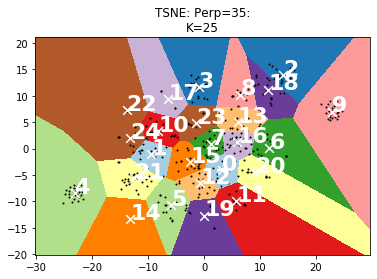

The best cluster was cluster 22
best df has shape (2514, 3)
reduce df final has shape (188, 3)
(188, 3)
Cluster 22 had a total return of -0.12951782966952374 in the first 3 quarters of 2019


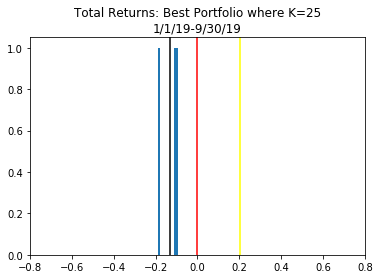

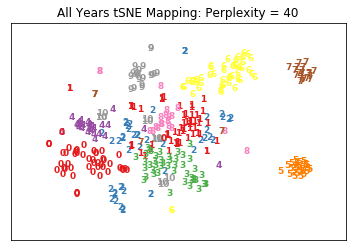

begin kmenans


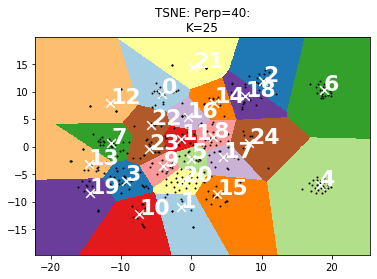

The best cluster was cluster 20
best df has shape (2514, 20)
reduce df final has shape (188, 20)
(188, 19)
Cluster 20 had a total return of 0.24181582990230266 in the first 3 quarters of 2019


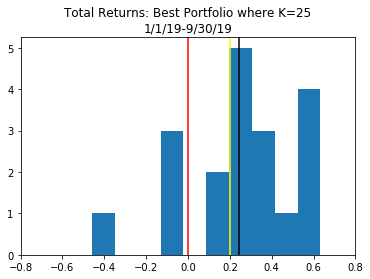

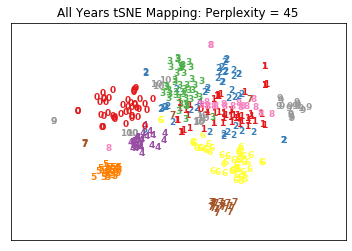

begin kmenans


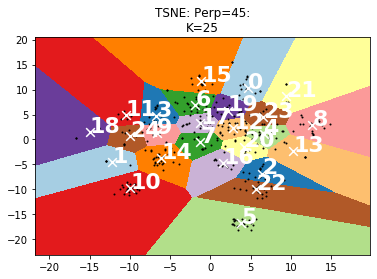

The best cluster was cluster 6
best df has shape (2514, 21)
reduce df final has shape (188, 21)
(188, 20)
Cluster 6 had a total return of 0.2454988750612687 in the first 3 quarters of 2019


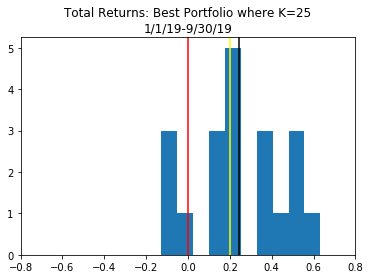

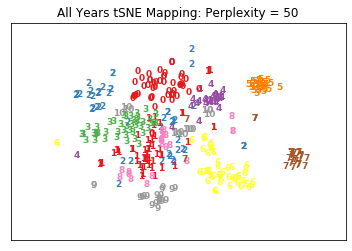

begin kmenans


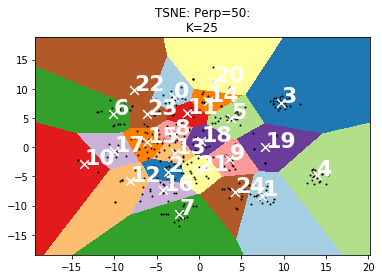

The best cluster was cluster 10
best df has shape (2514, 3)
reduce df final has shape (188, 3)
(188, 3)
Cluster 10 had a total return of 0.38672260525855157 in the first 3 quarters of 2019


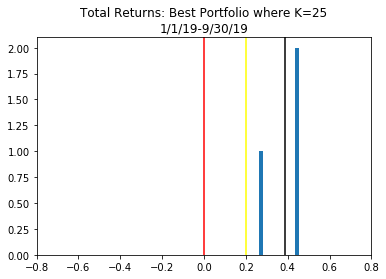

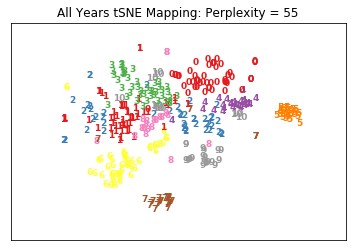

begin kmenans


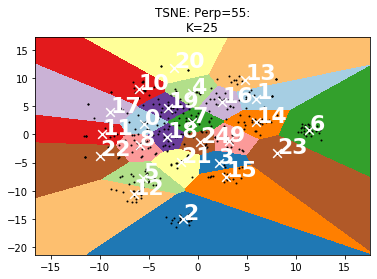

The best cluster was cluster 4
best df has shape (2514, 10)
reduce df final has shape (188, 10)
(188, 10)
Cluster 4 had a total return of 0.1698530177492676 in the first 3 quarters of 2019


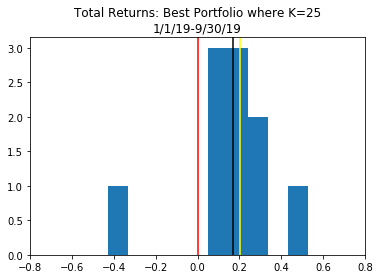

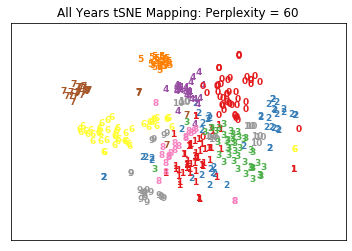

begin kmenans


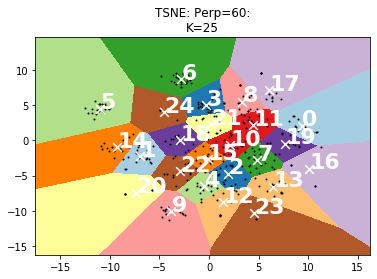

The best cluster was cluster 7
best df has shape (2514, 23)
reduce df final has shape (188, 23)
(188, 22)
Cluster 7 had a total return of 0.21988895004152065 in the first 3 quarters of 2019


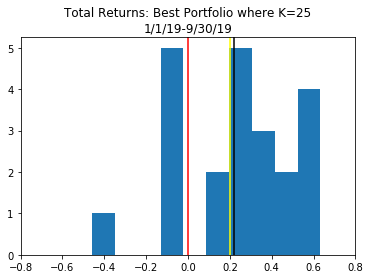

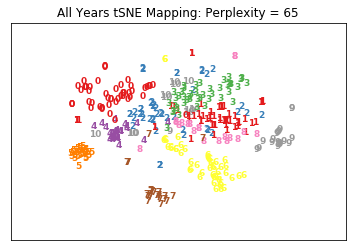

begin kmenans


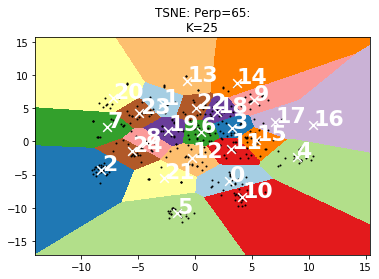

The best cluster was cluster 22
best df has shape (2514, 12)
reduce df final has shape (188, 12)
(188, 12)
Cluster 22 had a total return of 0.30609421881831017 in the first 3 quarters of 2019


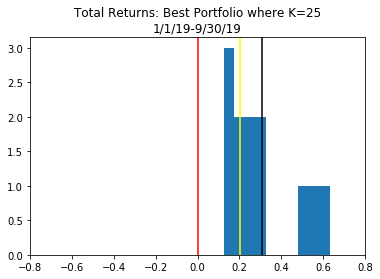

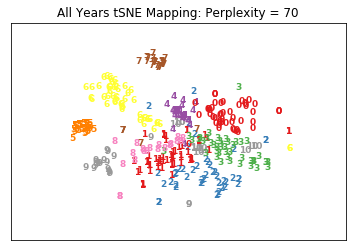

begin kmenans


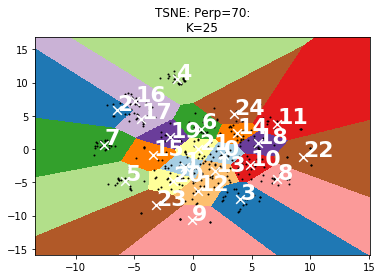

The best cluster was cluster 18
best df has shape (2514, 12)
reduce df final has shape (188, 12)
(188, 12)
Cluster 18 had a total return of 0.18531914988767487 in the first 3 quarters of 2019


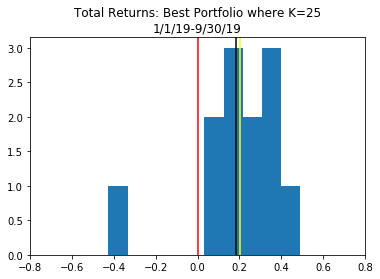

In [25]:
k_value = 25
dic_of_top_stocks = {}
for i in range(15,75,5):
    df_copy = df09_18.iloc[:, 2:].copy()
    perp = i
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=perp, learning_rate=50)
    t0 = time()
    X_all_tsne = tsne.fit_transform(X09_18)
    plot_embedding(X=X_all_tsne, y=y_all, title='All Years tSNE Mapping: Perplexity = {}'.format(perp))
    
    """BEGIN KMEANS"""
    print('begin kmenans')
    kmeans = colorize_kmeans(data=X_all_tsne, num_clusters=k_value, num_iter=10, title='TSNE: Perp={}:\nK={}'.format(i, k_value))
    #labels = pd.Series(kmeans.labels_)
    df_copy['cluster_labels'] = kmeans.labels_
    """LISTS OF THE MEANS RETURNS OF EVERY CLUSTER VALUE"""
    cluster_means_k = []
    cluster_vars_k = []

    for cluster_index in range(k_value):
        """FILTER BY CLUSTER VALUE"""
        temp_df = df_copy[df_copy['cluster_labels']==cluster_index].T.iloc[2:-1, :]
        stock_symbols = temp_df.columns
        """TEMP CLUSTER MEANS AND VARIANCES ACCROSS STOCKS"""
        cluster_means = []
        cluster_vars = []
        for symbol in stock_symbols:
            """FOR EVERY STOCK, TAKE THE AVERAGE RETURN AND AVERAGE VARIANCE"""
            
            temp_series = temp_df[[symbol]]
            temp_mean   = temp_series.mean()
            temp_var = temp_series.var()
            cluster_means.append(temp_mean[0])
            cluster_vars.append(temp_var[0])
            """ONCE THE AVERAGE RETURN AND AVERERAGE VARIANCE IS COMPUTED ACCROSS ALL STOCKS, APPEND TO THE EMPTY LISTS ABOVE"""    
        cluster_means_k.append(np.mean(cluster_means))
        cluster_vars_k.append(np.mean(cluster_vars))
        #print('cluster means appended')
    
    clusterk_means_num = []
    for cluster, mean in enumerate(cluster_means_k):
        """FOR EVERY ENUMERAATED CLUSTER APPEND THE CLUSTER VALUE AND MEAN RETURN AND SORT BY THAT"""
        #print(cluster, mean)
        clusterk_means_num.append((cluster, mean))
    ### sort the list
    clusterk_means_num.sort(key=lambda x: x[1], reverse=True) 
        
    ### pick index     
    index_best_cluster = clusterk_means_num[0][0]
    print('The best cluster was cluster {}'.format(index_best_cluster))
    
    best_df = df_copy[df_copy['cluster_labels']==index_best_cluster].T.iloc[2:-1, :]
    print('best df has shape {}'.format(best_df.shape))
    """merge the df whose cluster index has the highest avg return"""
    reduced_df_final = pd.merge(best_df.T.iloc[:, 0], df19, how='inner', on=None, left_on=None, right_on=None,
             left_index=True, right_index=True, sort=True,
             suffixes=('_x', '_y'), copy=True, indicator=False).T.iloc[3:, :]

    reduced_df_final.index = pd.to_datetime(reduced_df_final.index, format='%d/%b/%Y', infer_datetime_format=True)
    print('reduce df final has shape {}'.format(reduced_df_final.shape))
    ########
    ###########--------Merge with the price DF-------------#########
    #######
    prices = pd.merge(reduced_df_final.iloc[0, :].T, df_close19.T, how='inner', on=None, left_on=None, right_on=None,
             left_index=True, right_index=True, sort=True,
             suffixes=('_x', '_y'), copy=False, indicator=False).T.iloc[1:, ]
    print(prices.shape)
    returns = prices.apply(lambda x: total_return(x), axis=0)
    print('Cluster {} had a total return of {} in the first 3 quarters of 2019'.format(index_best_cluster, np.mean(returns)))
    
    
    """append dictionary... with the stock symbols that belonged to the cluster"""
    stocks_per_top_cluster = tuple(prices.columns)
    dic_of_top_stocks['k{}_perp{}'.format(k_value, perp)] = stocks_per_top_cluster
    #list_of_top_stocks.append(stocks_per_top_cluster)
    """what is the set of all clusters belonging to the top clusters?"""
    
    


    """plot the company returns of best average cluster"""
    sp_return = 0.20177154127199878
    plt.hist(returns, bins=10)
    plt.axvline(x=0., color='red')
    plt.axvline(x=sp_return, color='yellow')
    plt.axvline(x=np.mean(returns), color='black')
    plt.xlim(-0.8, 0.8)
    plt.title('Total Returns: Best Portfolio where K={}\n1/1/19-9/30/19'.format(k_value))
    #plt.savefig('Best_Portfolio3_2pca.png')
    plt.show()


In [34]:
stocks_set = []
for key, value in dic_of_top_stocks.items():
    temp_list = value
    for item in temp_list:
        stocks_set.append(item)

        
set(stocks_set)

{'A',
 'AAPL',
 'ABMD',
 'ADBE',
 'ADSK',
 'AKAM',
 'ANSS',
 'ATVI',
 'BSX',
 'CDNS',
 'CERN',
 'CI',
 'CMCSA',
 'COO',
 'CSCO',
 'CTSH',
 'CTXS',
 'DISH',
 'DXC',
 'EA',
 'EBAY',
 'FFIV',
 'HOLX',
 'HPQ',
 'HUM',
 'IBM',
 'IDXX',
 'IT',
 'JNPR',
 'MCO',
 'MSFT',
 'MSI',
 'MTD',
 'NTAP',
 'ORCL',
 'PKI',
 'QCOM',
 'SNPS',
 'SPGI',
 'STZ',
 'SYMC',
 'TMO',
 'TTWO',
 'UNH',
 'VAR',
 'VRSN',
 'WAT'}

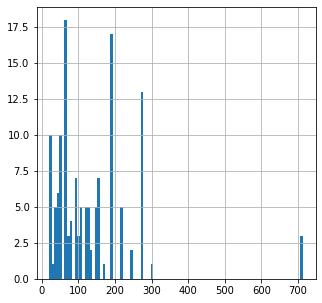

In [67]:
fig, ax = plt.subplots(nrows=1, ncols=1 , figsize=(5,5), frameon=False)
df_close19[stocks_set].apply(lambda x: np.mean(x), axis=0).hist(bins=100)

plt.show()

In [87]:
dic_of_top_stocks['k25_perp30']

('MCO', 'SPGI')

In [99]:
((df_close19.iloc[-1, :]-df_close19.iloc[0, :])*100/df_close19.iloc[0, :]).sort_values(ascending=False).to_csv('stock_max_returns.csv')

C:\PROGRA1\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  if __name__ == '__main__':


In [96]:
df_close19.apply(lambda x: np.max(x), axis=0).sort_values(ascending=False)

NVR      3766.27
BKNG     2077.44
AMZN     2020.99
GOOGL    1296.20
GOOG     1287.58
          ...   
FCX        14.20
COTY       13.73
AMCR       11.68
GE         10.88
F          10.51
Length: 501, dtype: float64

In [83]:
""" assuming we know the probability of selecting the symbo'ls return """
all_sp_mean = np.mean((df_close19.iloc[-1, :]-df_close19.iloc[0, :])*100/df_close19.iloc[0, :])

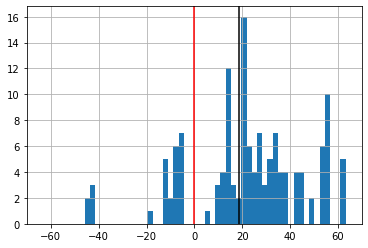

In [84]:
((df_close19[stocks_set].iloc[-1, :]-df_close19[stocks_set].iloc[0, :])*100/df_close19[stocks_set].iloc[0, :]).hist(bins=50)
plt.xlim(-70, 70)
plt.axvline(0, c='red')
plt.axvline(all_sp_mean, c='black')
plt.show()

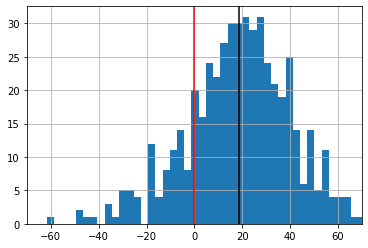

In [85]:
((df_close19.iloc[-1, :]-df_close19.iloc[0, :])*100/df_close19.iloc[0, :]).hist(bins=50)
plt.xlim(-70, 70)
plt.axvline(0, c='red')
plt.axvline(all_sp_mean, c='black')
plt.show()

In [ ]:
"""pick the 5 worst day in market history"""
"""perform kmeans on those stocks that continue to exist today"""
"""or in general given stocks that have survived for 20+ years"""